# Random walk visualization

This notebook provide a visualization of the evolution of stochastic processes. A special emphasis is regared to the central limit theorem. Some stochastic process can be generate within this notebook, and the evolution of the process can be visualized with the plots proposed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.special import erf
from scipy.stats import ecdf
from scipy.optimize import minimize

rng = np.random.default_rng(6)      # new recommended random generator of numpy

We define how many steps the stochastic process will take (_lenght_), and how many copies will be generated for it (_size_)

In [2]:
lenght = 30
size = 3000

We now define the random process, namely the probability rule for the increments of the process. All of them have zero-mean for the sake of simplicity.

We provide:
1) random walk
2) uniform step
3) cauchy step
4) Gaussian (normal) step

In [3]:
#Since the stochastic walk start in 0, we just need to generate lenght-1 increments NO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def step(step_size:int, lenght:int, size:int):
    x = rng.random((lenght,size))
    x = np.where(x > 0.5, step_size, -1*step_size)
    return x
def uniform(width, lenght:int, size:int):
    x = width * (rng.random((lenght, size)) - 0.5)
    return x
def cauchy(width, lenght:int, size:int): #width correspond to HWHM
    x = width * rng.standard_cauchy((lenght, size))
    return x
def normal(width, lenght:int, size:int):
    x = rng.normal(scale=width, size=(lenght, size))
    return x

We generate all the increments of the selected process in one single call. The output has a matrix shape _(lenght, size)_

In [4]:
#a = step(1,lenght, size)
a = uniform(1, lenght, size)

The stochastic process is realized by adding up all the increments.

In [5]:
def walk(x):
    S = np.cumsum(x, 0) #summation over the columns
    S = np.concatenate((np.zeros((1,size)), S), axis=0)
    return S
S = walk(a)

We now realize a plot to visualize all the stochastic walks we have generated

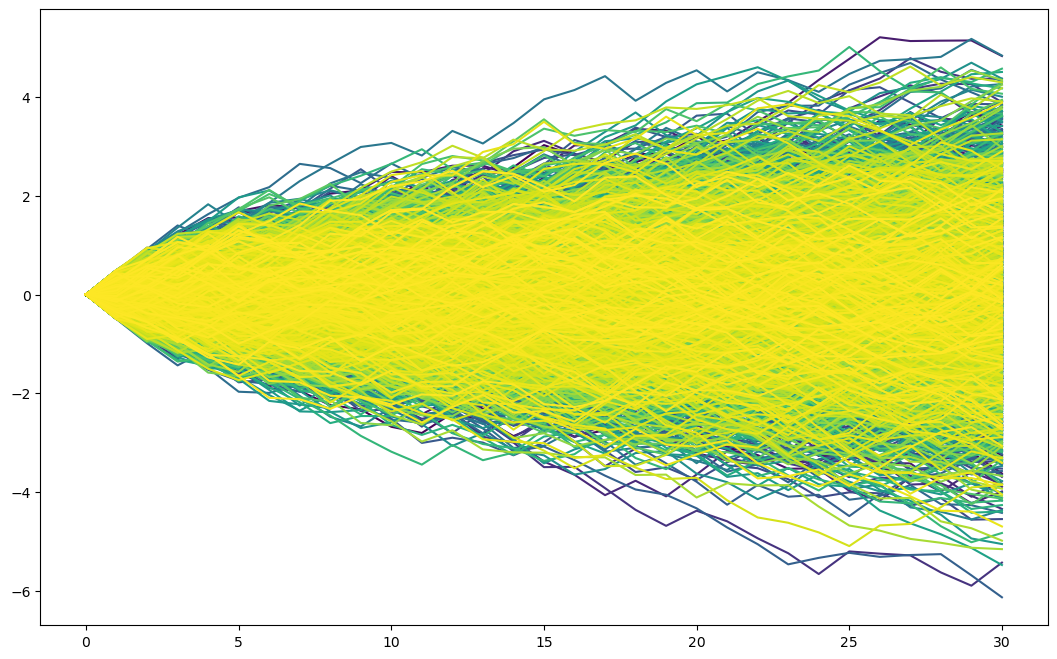

In [6]:
xx = np.arange(0, lenght + 1)  
fig, ax = plt.subplots(figsize=(13, 8))

color_map = colormaps.get_cmap('viridis').resampled(size)  # generate colors for all the walks
colors_rgb = [color_map(i)[:3] for i in range(size)]       # just do not take the trasparency parameter

for walk in range(size):                                   # we iterate over the columns of S
    ax.plot(xx, S[:, walk], color=colors_rgb[walk])

We now show the distribution of the walks as a function of the time-step performed. We also want to show the central limit theorem in action.

In [7]:
histograms = [np.histogram(S[i,:], bins='fd', density=True) for i in range(1,lenght)] # we use the Freedman-Diaconis rule for the binning
histograms.insert(0, np.histogram(S[0,:], bins=(-0.1, 0.1), density=True))            # at the beginning, the distribution is a Delta

<Axes: >

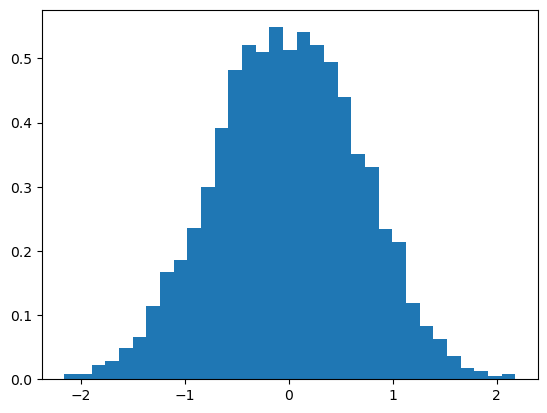

In [8]:
# auxilliary function to plot the distribution of the walks at a certain time-step
def plot_histogram(index:int):
    fig, ax = plt.subplots()
    centers = (histograms[index][1][0:-1] + histograms[index][1][1:]) * 0.5
    bin_width = np.abs(histograms[index][1][1] - histograms[index][1][0])
    ax.bar(centers, histograms[index][0], bin_width)
    return ax

plot_histogram(6)

We now show the evolution of the distribution as a function of time step

Text(0.5, 0.92, 'Evolution of the rescalated probability distribution')

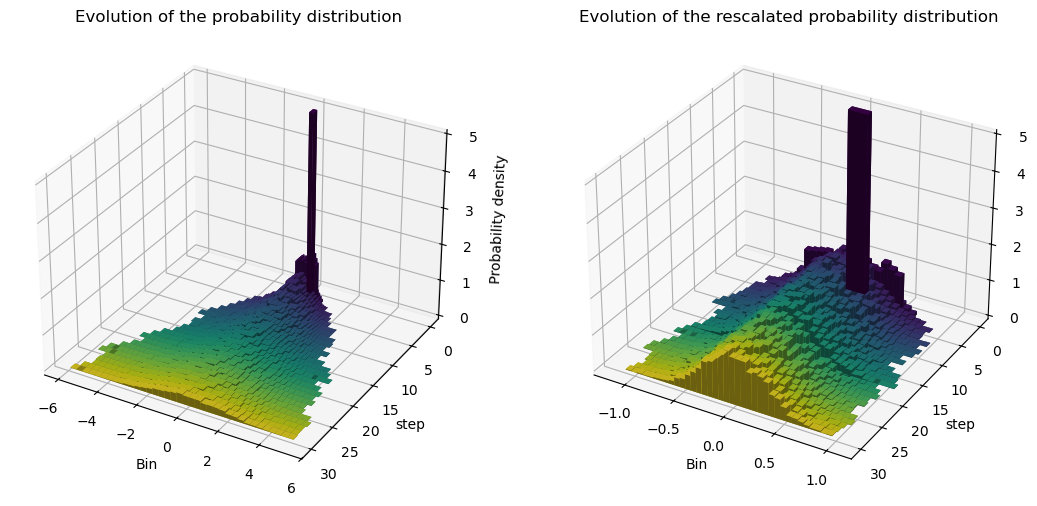

In [9]:
fig = plt.figure(figsize=(13, 8))
ax1 = fig.add_subplot(121, projection='3d')  # 1 stands for the plain histograms 
ax2 = fig.add_subplot(122, projection='3d')  # 2 stands for re-scalated histograms

color_map = colormaps.get_cmap('viridis').resampled(lenght)  # generate colors for all the walks
colors_rgb = [color_map(i)[:3] for i in range(lenght)]       # just do not take the trasparency parameter

hop = 1                        # how often the histograms are shown
for t, hist in enumerate(histograms):
    if t % hop != 0:
        continue  
    heights1 = hist[0]
    bins1 = hist[1]
    if t == 0:
        heights2 = heights1
        bins2 = bins1
    else:
        heights2 = heights1 * np.sqrt(t)
        bins2 = bins1 / np.sqrt(t)
    
    x1 = bins1[:-1]             # bars start by the left-edge of the bin
    x2 = bins2[:-1]
    
    y = np.full_like(x1, t)
    z = np.zeros_like(x1)
    
    dx1 = np.diff(bins1)         # array with the bin width
    dx2 = np.diff(bins2)
    
    dy = np.ones_like(x1)
    
    dz1 = heights1               # z correspond to the height of bins
    dz2 = heights2

    ax1.bar3d(x1, y, z, dx1, dy, dz1, shade=True, color=colors_rgb[t])
    ax2.bar3d(x2, y, z, dx2, dy, dz2, shade=True, color=colors_rgb[t])

ax1.invert_yaxis()
ax2.invert_yaxis()
#ax1.set_zlim(0, 1.25)

# labels
ax1.set_xlabel('Bin')
ax1.set_ylabel('step')
ax1.set_zlabel('Probability density')
ax1.set_title('Evolution of the probability distribution')

ax2.set_xlabel('Bin')
ax2.set_ylabel('step')
ax2.set_zlabel('Probability density')
ax2.set_title('Evolution of the rescalated probability distribution')

Let's check if at the end of the walk we end up with a Gaussian-like distribution. We must give the variance of the stochastic process chosen.

In [10]:
variance = 1/12              # for a uniform distribution with witdh 1

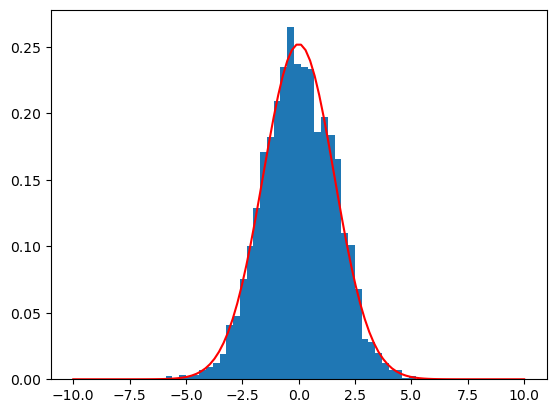

In [11]:
xx = np.linspace(-10,10,100)
sigma2 = variance * lenght        # variance of the walk according to the central limit theorem 
gaussian = 1/(np.sqrt(2*np.pi*sigma2))*np.exp(-xx**2/(2*sigma2)) # evalutation of the guassian shape 

plot_histogram(lenght-1)          # plot the histogram for the final position of the process
plt.plot(xx, gaussian, color='r') #the red line is the Gaussian pdf

Let us perform a Pearson $\chi^2$ test to assess the Normal shape of the histogram

In [12]:
hist = histograms[-1][0]
edges = histograms[-1][1]

# gaussian cdf computed for the histogram using the error function
gcdf = 0.5 * (1 + erf( edges / np.sqrt(2*sigma2) ))
gcdf = np.diff(gcdf)   # this gives the area of the bins according to the gaussian distribution function

chi2 = np.sum(np.power(hist - gcdf,2) / gcdf)
print('The result is {:0.2f}'.format(chi2))

The result is 5.64


At _lenght_$=30$, we get $\chi^2 < 6$, that is quite small, in agreement with the expected Gaussian shape. Such agreement is good enough for most of empirical analysis. 

Another test check the Gaussian tendency of the random walk is given by the _Berry-Esseen_ inequality:

$$|F(S) - \Phi(S)| \leq \frac{3\rho}{\sigma^3 \sqrt{n}}$$

where $F(S)$ is the (empirical) scaled cumulative distribution function of the stochastic process, whereas $\Phi(S)$ is the asymptotic scaled normal distribution function.


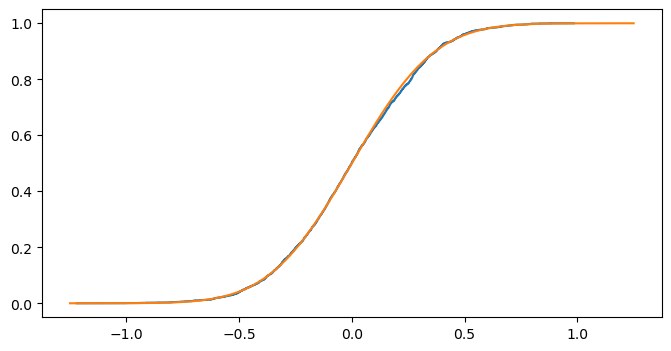

In [33]:
fig, ax = plt.subplots(figsize=(8,4))
xx = np.linspace(-1.25, 1.25, 1000)

F = ecdf(S[-1,:] / np.sqrt(lenght))         # empirical scaled cumulative function

F.cdf.plot(ax)                              # plotted as suggested by scipy documentation
ax.plot(xx, 0.5*(1+erf(xx/(np.sqrt(2*variance))))) # scaled normal cumulative function

For the particular case of uniform distribution, we have
$$E[|x|^3] = \rho=\frac{1}{32}$$

In [29]:
rho = 1/32

Let us compute and check $$ \max{|F(S) - \Phi(S)|} \leq \frac{3\rho}{\sigma^3 \sqrt{n}}$$
Let's find the x value corresponding to the maximum, in the simplest way

In [32]:
diff = np.abs(F.cdf.evaluate(xx) - 0.5*(1+erf(xx/(np.sqrt(2*variance))))) # sampling of |F(S)-Phi(S)| 
maximum = np.max(diff)  # find the x value for which the gap is maximum

bound = 3*rho/(np.sqrt(variance**3 * lenght))
print(maximum, "<=", bound)

0.021851490335667467 <= 0.7115124735378855
